In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
#loading datasets
customers_df = pd.read_csv("/Users/a12345/Desktop/DATA PT /ML Project/02_data/Blinkit/blinkit_customers.csv")
orders_df = pd.read_csv("/Users/a12345/Desktop/DATA PT /ML Project/02_data/Blinkit/blinkit_orders.csv")
order_items_df = pd.read_csv("/Users/a12345/Desktop/DATA PT /ML Project/02_data/Blinkit/blinkit_order_items.csv")
feedback_df = pd.read_csv("/Users/a12345/Desktop/DATA PT /ML Project/02_data/Blinkit/blinkit_customer_feedback.csv")

In [61]:
feedback_df.head()

,feedback_id,order_id,customer_id,rating,feedback_text,feedback_category,sentiment,feedback_date
0,2234710,1961864118,30065862,4,"It was okay, nothing special.",Delivery,Neutral,2024-07-17
1,5450964,1549769649,9573071,3,The order was incorrect.,App Experience,Negative,2024-05-28
2,482108,9185164487,45477575,3,"It was okay, nothing special.",App Experience,Neutral,2024-09-23
3,4823104,9644738826,88067569,4,The product met my expectations.,App Experience,Neutral,2023-11-24
4,3537464,5427684290,83298567,3,Product was damaged during delivery.,Delivery,Negative,2023-11-20


In [45]:
#merge datasets
merged_df = customers_df.merge(orders_df, on="customer_id", how="left")
merged_df = merged_df.merge(order_items_df, on="order_id", how="left")
merged_df = merged_df.merge(feedback_df[['customer_id', 'rating', 'sentiment']], on="customer_id", how="left")

In [46]:
#Feature Engineering
merged_df["registration_date"] = pd.to_datetime(merged_df["registration_date"])
merged_df["tenure_days"] = (pd.to_datetime("today") - merged_df["registration_date"]).dt.days
merged_df["total_spent"] = merged_df["quantity"] * merged_df["unit_price"]

In [47]:
# Aggregate features for clustering
cluster_df = merged_df.groupby("customer_id").agg(
    total_orders=("order_id", "nunique"),
    avg_order_value=("order_total", "mean"),
    total_spent=("total_spent", "sum"),
    avg_quantity_per_order=("quantity", "mean"),
    avg_rating=("rating", "mean"),
    sentiment_score=("sentiment", lambda x: (x == "positive").mean()),
    tenure_days=("tenure_days", "mean")
).reset_index()

In [48]:
#drop customer_id
cluster_df.drop(columns=["customer_id"], inplace=True)

#dropping sentiment score
cluster_df.drop(columns=["sentiment_score"], inplace=True)

#filling missing values
cluster_df.fillna(cluster_df.mean(), inplace=True)

In [49]:
#Standard Scaler
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

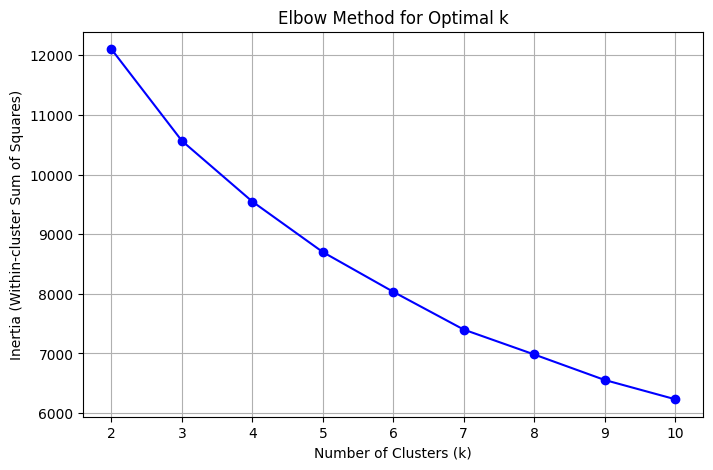

In [50]:
#Elbow Method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

#visualising
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [51]:
# Apply K-Means clustering with optimal k
optimal_k = k_values[np.argmin(np.diff(inertia)) + 1]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_df["cluster"] = kmeans.fit_predict(cluster_scaled)

optimal_k

3

In [52]:
# Display first few rows of the clustered dataset
cluster_df.head()

,total_orders,avg_order_value,total_spent,avg_quantity_per_order,avg_rating,tenure_days,cluster
0,2,2863.020000,8306.10,2.500000,2.000000,328.0,1
1,0,2192.695847,0.00,2.014493,3.339620,461.0,1
2,3,2614.966667,9374.73,1.333333,3.666667,220.0,0
3,0,2192.695847,0.00,2.014493,3.339620,166.0,1
4,4,3692.192500,6700.00,1.500000,3.500000,581.0,0


In [53]:
cluster_df.cluster.value_counts()

1    1152
0     789
2     559
Name: cluster, dtype: int64

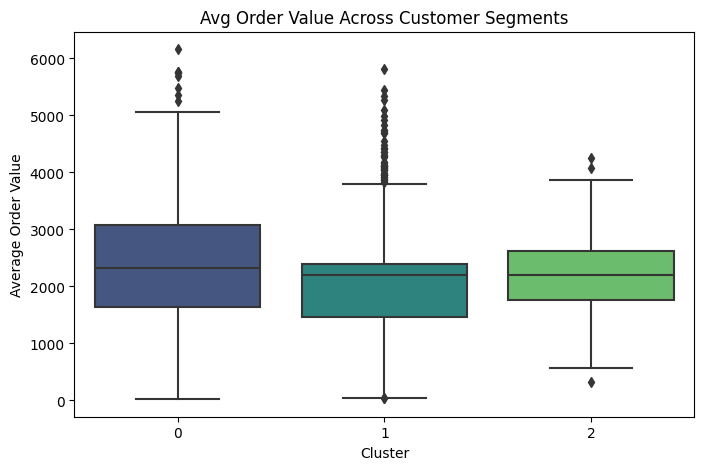

In [54]:
# Box plot to compare avg order value per cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x=cluster_df["cluster"], y=cluster_df["avg_order_value"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Average Order Value")
plt.title("Avg Order Value Across Customer Segments")
plt.show()

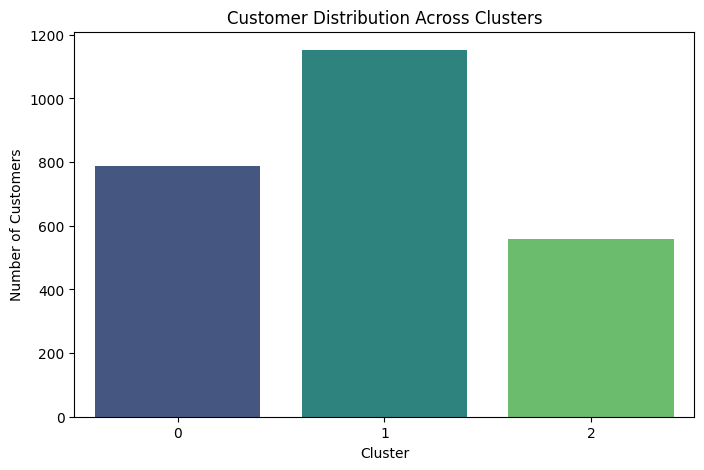

In [55]:
plt.figure(figsize=(8, 5))
sns.countplot(x=cluster_df["cluster"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()

In [56]:
from sklearn.metrics import silhouette_score

#silhouette score
silhouette_avg = silhouette_score(cluster_scaled, cluster_df["cluster"])
print(f"Silhouette Score: {silhouette_avg:.3f}")


Silhouette Score: 0.175


In [57]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune these hyperparameters
labels_dbscan = dbscan.fit_predict(cluster_scaled)

# Compute Silhouette Score for DBSCAN
score_dbscan = silhouette_score(cluster_scaled, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1
print(f"DBSCAN Silhouette Score: {score_dbscan:.3f}")

DBSCAN Silhouette Score: -0.311


In [58]:
best_k = None
best_score = -1

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(cluster_scaled)
    score = silhouette_score(cluster_scaled, labels)
    
    print(f"k={k}, Silhouette Score: {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest k: {best_k} with Silhouette Score: {best_score:.3f}")

k=2, Silhouette Score: 0.209
k=3, Silhouette Score: 0.175
k=4, Silhouette Score: 0.166
k=5, Silhouette Score: 0.171
k=6, Silhouette Score: 0.170
k=7, Silhouette Score: 0.174
k=8, Silhouette Score: 0.173
k=9, Silhouette Score: 0.203
k=10, Silhouette Score: 0.178

Best k: 2 with Silhouette Score: 0.209


In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(cluster_scaled, cluster_df["cluster"])
importances = rf.feature_importances_

# Show feature importance
feature_importance = pd.DataFrame({"Feature": cluster_df.columns[:-1], "Importance": importances})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                  Feature  Importance
2             total_spent    0.564747
3  avg_quantity_per_order    0.305514
1         avg_order_value    0.040444
0            total_orders    0.036308
4              avg_rating    0.035948
5             tenure_days    0.017038


In [ ]:
# Save the clustered dataset
cluster_df.to_csv("clustered_customer_segments.csv", index=False)